In [1]:
!pip install rasterio geopandas matplotlib requests

import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io
from rasterio.mask import mask


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 26.9 MB/s eta 0:00:00


In [2]:
import requests, zipfile, io, os

url = 'https://api.globalsolaratlas.info/download/USA/USA_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF.zip'

zip_path = "data/usa_solar.zip"
extract_dir = "data/usa_solar"

os.makedirs("data", exist_ok=True)


if not os.path.exists(zip_path):
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)
    print("Downloaded USA Solar dataset")

# Extract files
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
    print("Extracted USA Solar GeoTIFFs")






Downloaded USA Solar dataset
Extracted USA Solar GeoTIFFs


In [3]:
import os

# List extracted files
for f in os.listdir(extract_dir):
    print(f)


extract_dir = "data/usa_solar/USA_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF"

files = os.listdir(extract_dir)
print(files)

west_dir = "data/usa_solar/USA_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF/western-hemisphere"

files = os.listdir(west_dir)
print(files)



USA_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF
['eastern-hemisphere', 'western-hemisphere']
['OPTA.tif.aux.xml', 'DIF.tif.pdf', 'DIF.tif.xml', 'TEMP.tif.aux.xml', 'GTI.tif.aux.xml', 'GHI.tif.pdf', 'GTI.tif', 'PVOUT.tif', 'DNI.tif', 'GHI.tif.xml', 'DNI.tif.pdf', 'DIF.tif.aux.xml', 'OPTA.tif.pdf', 'DIF.tif', 'DNI.tif.aux.xml', 'GTI.tif.xml', 'OPTA.tif', 'OPTA.tif.xml', 'GTI.tif.pdf', 'TEMP.tif.pdf', 'DNI.tif.xml', 'PVOUT.tif.xml', 'PVOUT.tif.aux.xml', 'PVOUT.tif.pdf', 'TEMP.tif', 'TEMP.tif.xml', 'monthly', 'GHI.tif.aux.xml', 'GHI.tif']


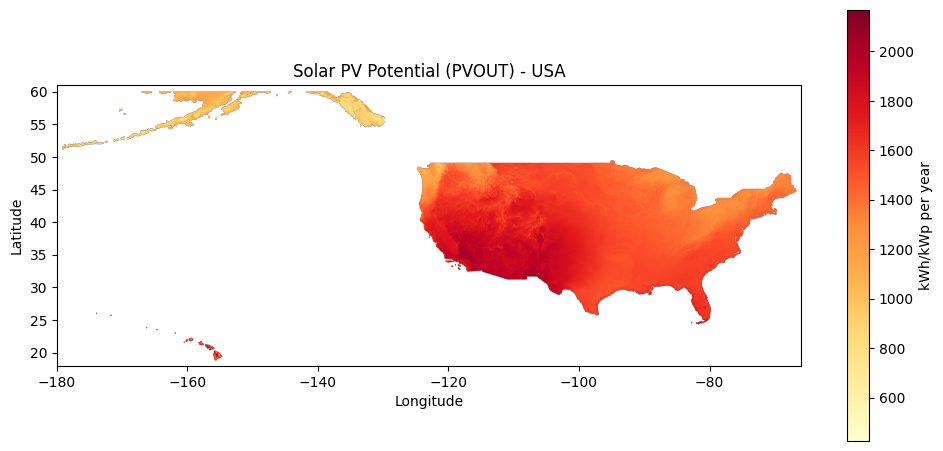

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd

# Path to PVOUT.tif
pvout_path = "data/usa_solar/USA_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF/western-hemisphere/PVOUT.tif"

# Open raster
with rasterio.open(pvout_path) as src:
    pvout = src.read(1)
    transform = src.transform

# Plot with proper colorbar
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.imshow(pvout, cmap="YlOrRd", extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
plt.title("Solar PV Potential (PVOUT) - USA")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add colorbar with label
cbar = plt.colorbar(cax, ax=ax, shrink=0.7)
cbar.set_label("kWh/kWp per year")

plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 53.5 MB/s eta 0:00:00


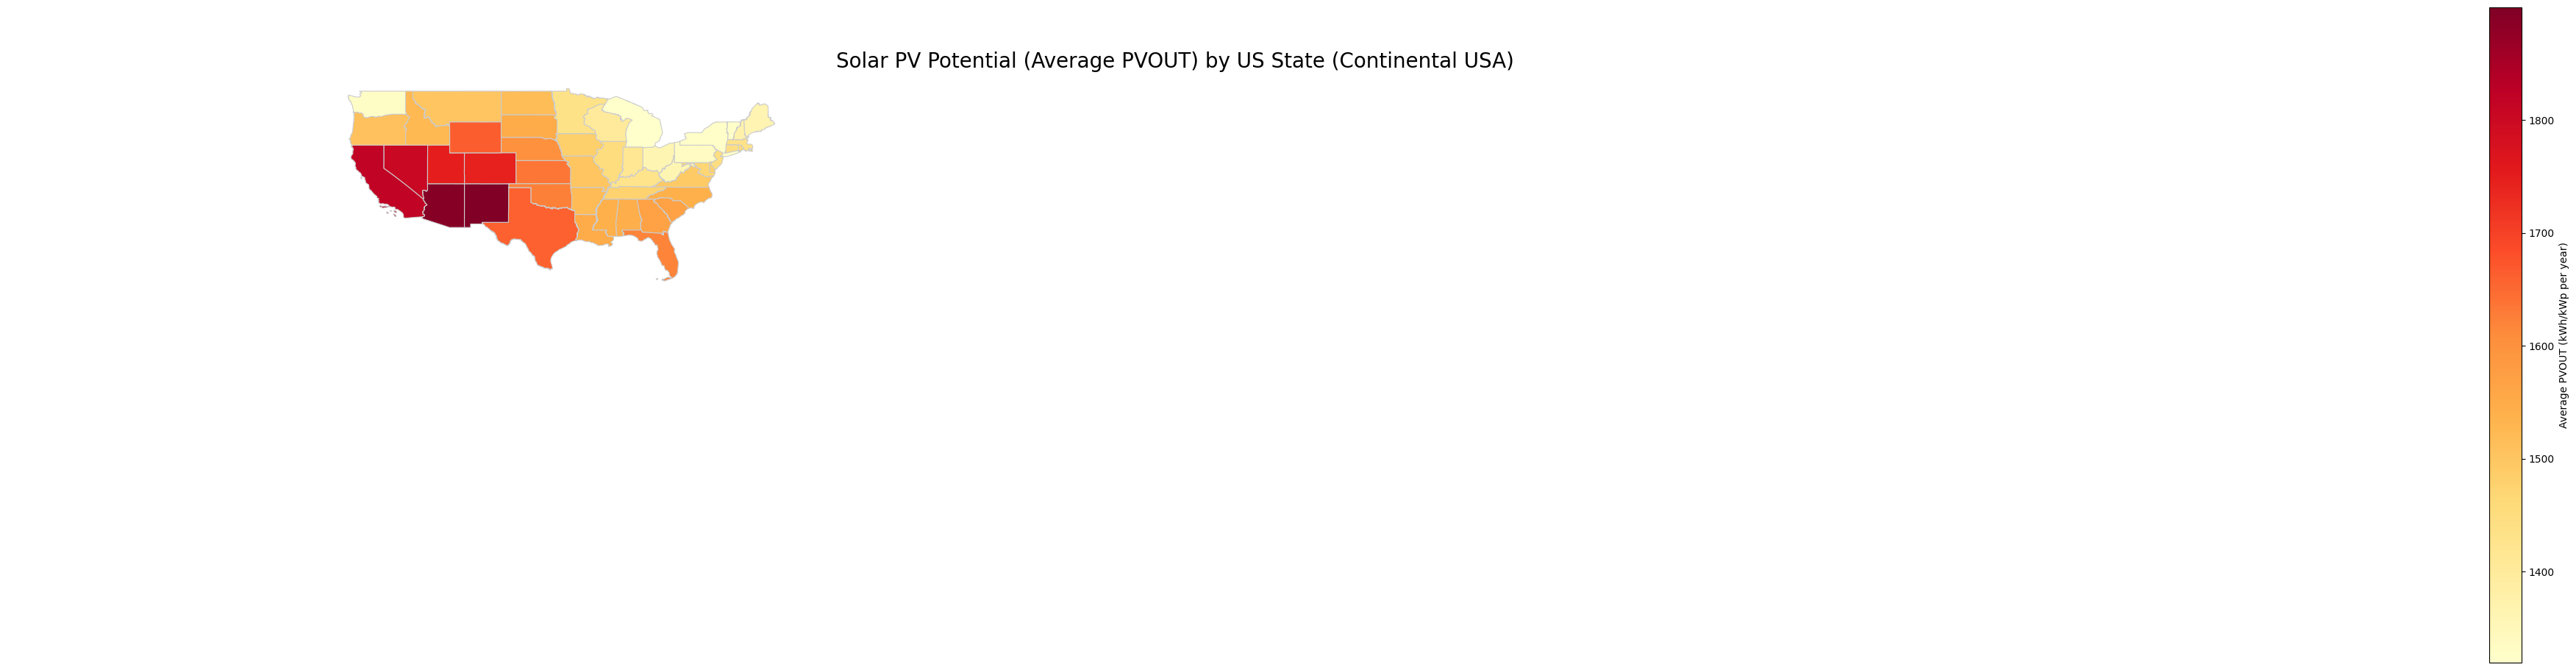

In [7]:
!pip install rasterstats
import geopandas as gpd
import rasterio
import rasterstats
import matplotlib.pyplot as plt

states = gpd.read_file("data/usa_shapefile/us-state-boundaries.shp")

raster_path = "data/usa_solar/USA_GISdata_LTAy_YearlyMonthlyTotals_GlobalSolarAtlas-v2_GEOTIFF/western-hemisphere/PVOUT.tif"
raster = rasterio.open(raster_path)

if states.crs != raster.crs:
    states = states.to_crs(raster.crs)

stats = rasterstats.zonal_stats(
    vectors=states,
    raster=raster_path,
    stats="mean",
    nodata=raster.nodata,
    geojson_out=False
)

states["pvout_mean"] = [s["mean"] for s in stats]

# Filter out Alaska and Hawaii for plotting
continental_states = states[~states['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]


fig, ax = plt.subplots(figsize=(40, 30))  # Increased figure size
continental_states.plot(
    column="pvout_mean",
    cmap="YlOrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    legend_kwds={"label": "Average PVOUT (kWh/kWp per year)", "shrink": 0.3}
)

ax.set_title("Solar PV Potential (Average PVOUT) by US State (Continental USA)", fontsize=20, pad=20)
ax.set_axis_off()

ax.set_xlim(continental_states.total_bounds[[0, 2]])  # minx, maxx
ax.set_ylim(continental_states.total_bounds[[1, 3]])  # miny, maxy

plt.tight_layout()
plt.show()

In [20]:
#EDA
import pandas as pd
import geopandas as gpd


df = pd.read_csv("amazon_data_centers.csv")

df = df[df["Latitude"] != "-"]
df = df[df["Longitude"] != "-"]

df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"
)

print(gdf.head())


       Continent           Location        Country  Latitude  Longitude  \
0  North America  Ashburn, Virginia  United States   39.0215   -77.4579   
2  North America   Boardman, Oregon  United States   45.8696  -119.6880   
3  North America       Dublin, Ohio  United States   40.1386   -83.0901   
4  North America   Montreal, Quebec         Canada   45.5040   -73.5747   
5         Europe          Frankfurt        Germany   50.1109     8.6821   

  Year Established                  geometry  
0                -  POINT (-77.4579 39.0215)  
2                -  POINT (-119.688 45.8696)  
3                -  POINT (-83.0901 40.1386)  
4                -   POINT (-73.5747 45.504)  
5                -    POINT (8.6821 50.1109)  


In [21]:
import pandas as pd
import geopandas as gpd

def load_datacenters(path, company):
    df = pd.read_csv(path)

    df = df[(df["Latitude"] != "-") & (df["Longitude"] != "-")]
    df["Latitude"] = df["Latitude"].astype(float)
    df["Longitude"] = df["Longitude"].astype(float)

    df["Company"] = company

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
        crs="EPSG:4326"
    )
    return gdf

#Load all companies
amazon_gdf = load_datacenters("amazon_data_centers.csv", "Amazon")
google_gdf = load_datacenters("google_data_centers.csv", "Google")
meta_gdf   = load_datacenters("meta_data_centers.csv", "Meta")
microsoft_gdf = load_datacenters("microsoft_data_centers.csv", "Microsoft")

#Combining into one dataframe
all_gdf = pd.concat([amazon_gdf, google_gdf, meta_gdf, microsoft_gdf], ignore_index=True)
all_gdf = gpd.GeoDataFrame(all_gdf, geometry="geometry", crs="EPSG:4326")

#Reproject to match US shapefile CRS
all_gdf = all_gdf.to_crs(continental_states.crs)

#Filter only US datacenters (using attribute filter)
all_gdf_us = all_gdf[all_gdf["Country"] == "United States"]


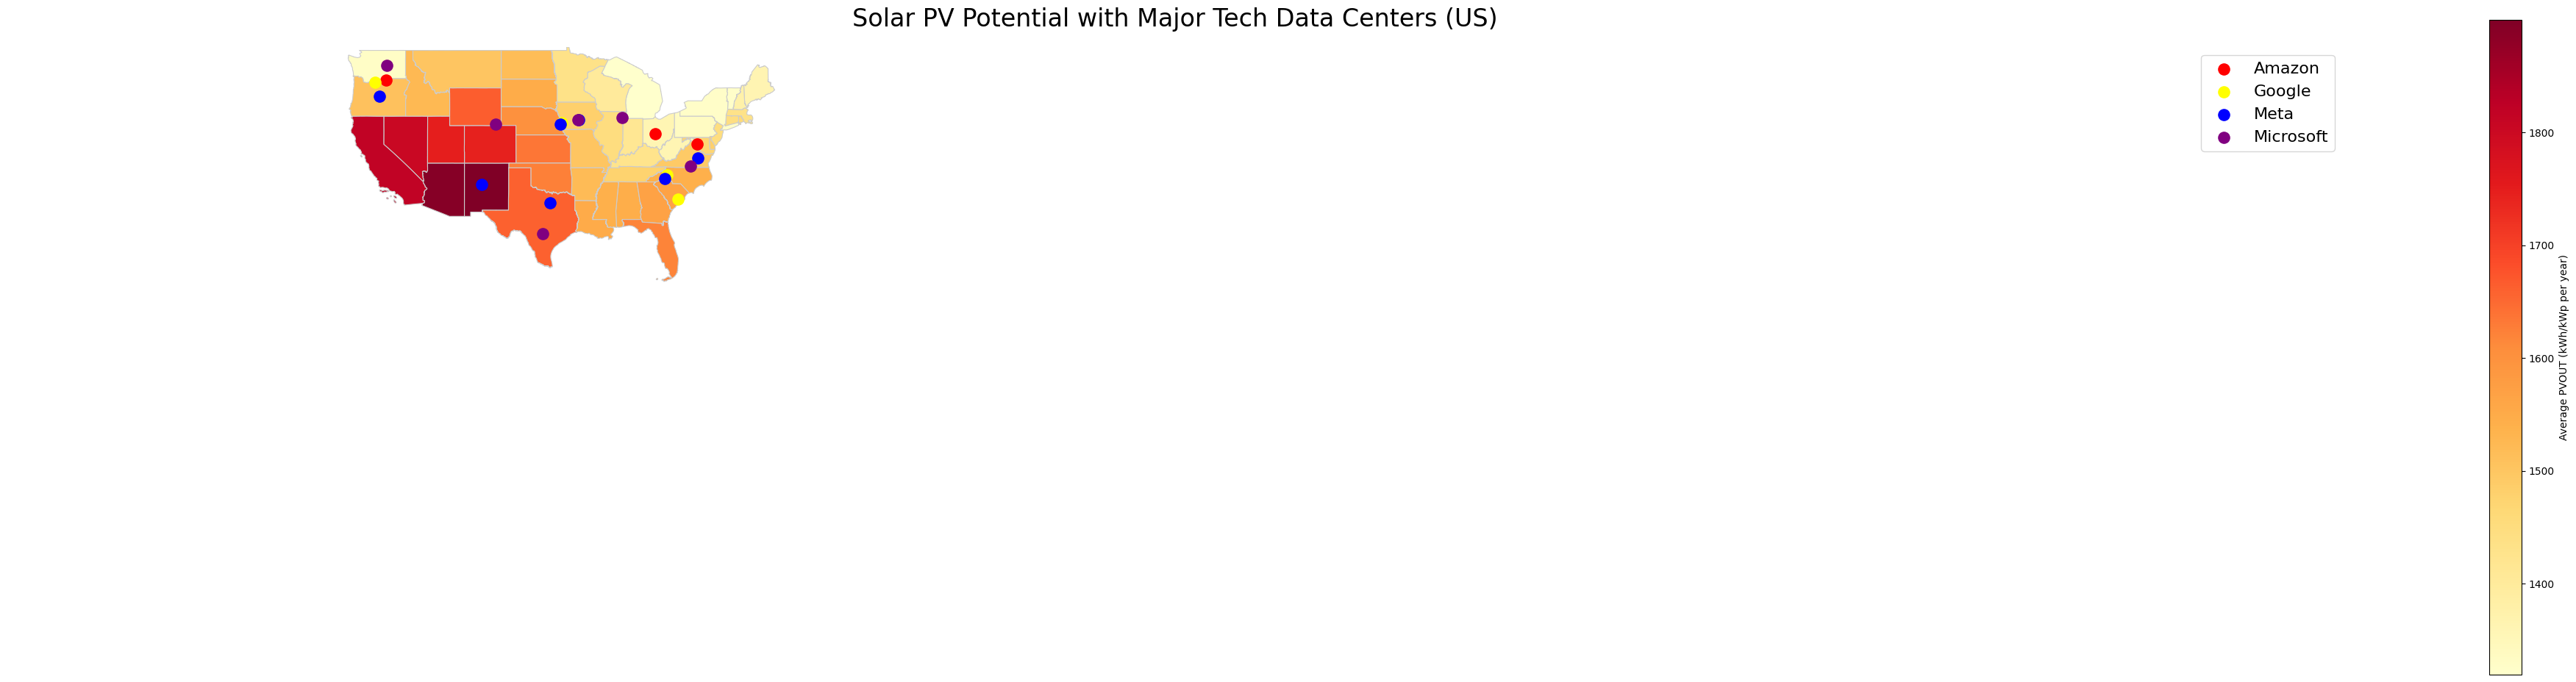

In [22]:
fig, ax = plt.subplots(figsize=(40, 30))

#Base solar PV map
continental_states.plot(
    column="pvout_mean",
    cmap="YlOrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
    legend_kwds={"label": "Average PVOUT (kWh/kWp per year)", "shrink": 0.3}
)

#Overlay datacenters by company
companies = all_gdf_us["Company"].unique()
colors = {"Amazon": "red", "Google": "yellow", "Meta": "blue", "Microsoft": "purple"}

for company in companies:
    subset = all_gdf_us[all_gdf_us["Company"] == company]
    subset.plot(ax=ax, color=colors[company], markersize=120, marker="o", label=company)

ax.set_title("Solar PV Potential with Major Tech Data Centers (US)", fontsize=24, pad=20)
ax.set_axis_off()
ax.set_xlim(continental_states.total_bounds[[0, 2]])
ax.set_ylim(continental_states.total_bounds[[1, 3]])
ax.legend(fontsize=16)

plt.tight_layout()
plt.show()
